In [ ]:
!pip install --no-cache-dir scikit-learn pandas numpy matplotlib imbalanced-learn joblib


In [ ]:
import sys
print(sys.executable)


In [4]:
print("Helo world")

Helo world


In [ ]:
%pip install pandas numpy scikit-learn matplotlib joblib imbalanced-learn


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import joblib
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline


In [9]:
DATA_PATH = "kaggle dataset/archive/creditcard.csv"  # put your file in same folder
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Shape: (284807, 31)
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
0    284315
1       492
Name: count, dtype: int64


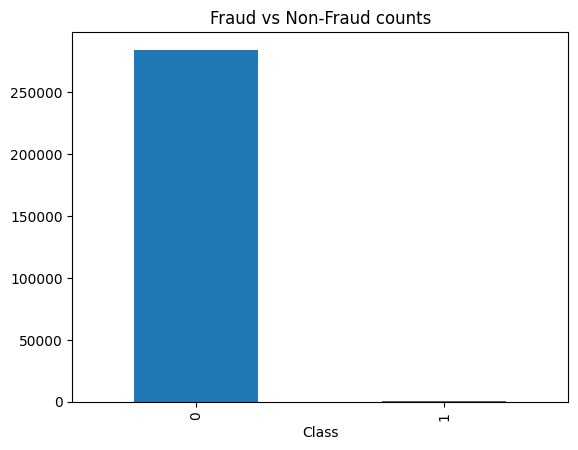

In [10]:
counts = df['Class'].value_counts()
print(counts)
counts.plot(kind='bar', title='Fraud vs Non-Fraud counts')
plt.show()


In [11]:
X = df.drop(columns=['Class'])
y = df['Class']

# Drop 'Time' (optional)
if 'Time' in X.columns:
    X = X.drop(columns=['Time'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape


((227845, 29), (56962, 29))

In [12]:
pipe_a = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        solver='liblinear', class_weight='balanced', max_iter=1000, random_state=42
    ))
])

param_grid = {'logreg__C': [0.01, 0.1, 1, 10]}
clf_a = GridSearchCV(pipe_a, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
clf_a.fit(X_train, y_train)

print("Best params:", clf_a.best_params_)
print("Best CV ROC AUC:", clf_a.best_score_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'logreg__C': 0.01}
Best CV ROC AUC: 0.9832092813267502


In [13]:
y_pred_a = clf_a.predict(X_test)
y_proba_a = clf_a.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_a, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba_a))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_a))


              precision    recall  f1-score   support

           0     0.9999    0.9753    0.9874     56864
           1     0.0603    0.9184    0.1131        98

    accuracy                         0.9752     56962
   macro avg     0.5301    0.9468    0.5503     56962
weighted avg     0.9982    0.9752    0.9859     56962

ROC AUC: 0.9717098009715984
Confusion matrix:
 [[55461  1403]
 [    8    90]]


In [14]:
rus = RandomUnderSampler(random_state=42)
pipe_b = ImbPipeline([
    ('rus', rus),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        solver='liblinear', max_iter=1000, random_state=42
    ))
])

pipe_b.fit(X_train, y_train)
y_pred_b = pipe_b.predict(X_test)
y_proba_b = pipe_b.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_b, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba_b))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_b))


              precision    recall  f1-score   support

           0     0.9999    0.9722    0.9858     56864
           1     0.0538    0.9184    0.1017        98

    accuracy                         0.9721     56962
   macro avg     0.5268    0.9453    0.5438     56962
weighted avg     0.9982    0.9721    0.9843     56962

ROC AUC: 0.9740777853065818
Confusion matrix:
 [[55282  1582]
 [    8    90]]


In [15]:
roc_a = roc_auc_score(y_test, y_proba_a)
roc_b = roc_auc_score(y_test, y_proba_b)

if roc_a >= roc_b:
    chosen = clf_a.best_estimator_
    chosen_name = 'logreg_classweight.joblib'
else:
    chosen = pipe_b
    chosen_name = 'logreg_undersample.joblib'

joblib.dump(chosen, chosen_name)
print(f"Saved {chosen_name}")


Saved logreg_undersample.joblib


In [16]:
# Load model
model = joblib.load('logreg_undersample.joblib')  # or classweight version

# Pick one transaction from test set
sample = X_test.sample(1, random_state=42)

# Predict
pred = model.predict(sample)
prob = model.predict_proba(sample)[:, 1]

print("Predicted class:", pred[0])  # 0 or 1
print("Fraud probability:", prob[0])


Predicted class: 0
Fraud probability: 0.007961095003260464
